In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import jax
import numpy as np
import matplotlib.pyplot as plt
from confirm.lewislib import lewis
import confirm.imprint as ip

In [2]:
name = "1d_slice"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}

In [3]:
import os
import time
import modal
import pandas as pd
import confirm.cloud.modal_util as modal_util

stub = modal.Stub("confirm")

img = modal_util.get_image()


@stub.function(
    image=img,
    gpu=modal.gpu.A100(),
    retries=0,
    mounts=modal.create_package_mounts(["confirm"]),
    timeout=60 * 60 * 2,
)
def cloud_validate(g, *, K, params):
    start = time.time()
    rej_df = ip.validate(
        lewis.Lewis45Model,
        g,
        lam=0.06253,
        K=K,
        tile_batch_size=200,
        model_kwargs=params,
    )
    print(time.time() - start)
    return rej_df


def parallel_validate(g, *, n_workers, K, params):
    gs = [ip.grid.Grid(d, g.null_hypos) for d in np.array_split(g.df, n_workers)]
    rej_dfs = list(
        cloud_validate.map(gs, kwargs={"K": K, "params": params}, order_outputs=True)
    )
    return pd.concat(rej_dfs)


with stub.run():
    rej_df = parallel_validate(g, n_workers=2, K=2**20, params=params)
    # rej_df = cloud_validate(g, K=2**20, params=params)

In [4]:
g = ip.cartesian_grid([-1, -10], [1, -1], n=[10, 2000])
g.df["theta3"] = g.df["theta1"]
g.df["theta1"] = g.df["theta0"]
g.df["theta2"] = g.df["theta0"]
g.df["radii3"] = g.df["radii1"]
g.df["radii0"] = 0
g.df["radii1"] = 0
g.df["radii2"] = 0
g.df["null_truth0"] = True
g.df["null_truth1"] = True
g.df["null_truth2"] = True

In [5]:
# import pandas as pd
# rej_df = pd.read_parquet("./1d_slice/1d_orthogonal_ada.parquet")
# rej_df
# boundcost = rej_df['tie_bound'] - rej_df['tie_cp_bound']
# refine = boundcost > 0.001
# g_refine = g.subset(refine).refine()
# g_new = g_refine.concat(g.subset(~refine))
# new_t3 = np.sort(np.unique(g_new.df['theta3']))
# new_t3.shape[0]
# plt.plot(new_t3, '*')
# plt.show()

In [6]:
with stub.run():
    rej_df = parallel_validate(g, n_workers=2, K=2**20, params=params)
    # rej_df = cloud_validate(g, K=2**20, params=params)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-SoxHi48swiNI4ta9SViphC

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

Runner failed with exception: Worker disappeared, in-progress inputs will be re-scheduled

In [8]:
rej_df.to_parquet("./1d_slice/1d_orthogonal_ada.parquet")

In [11]:
import pandas as pd

rej_df = pd.read_parquet("./1d_slice/1d_orthogonal_ada.parquet")
rej_df

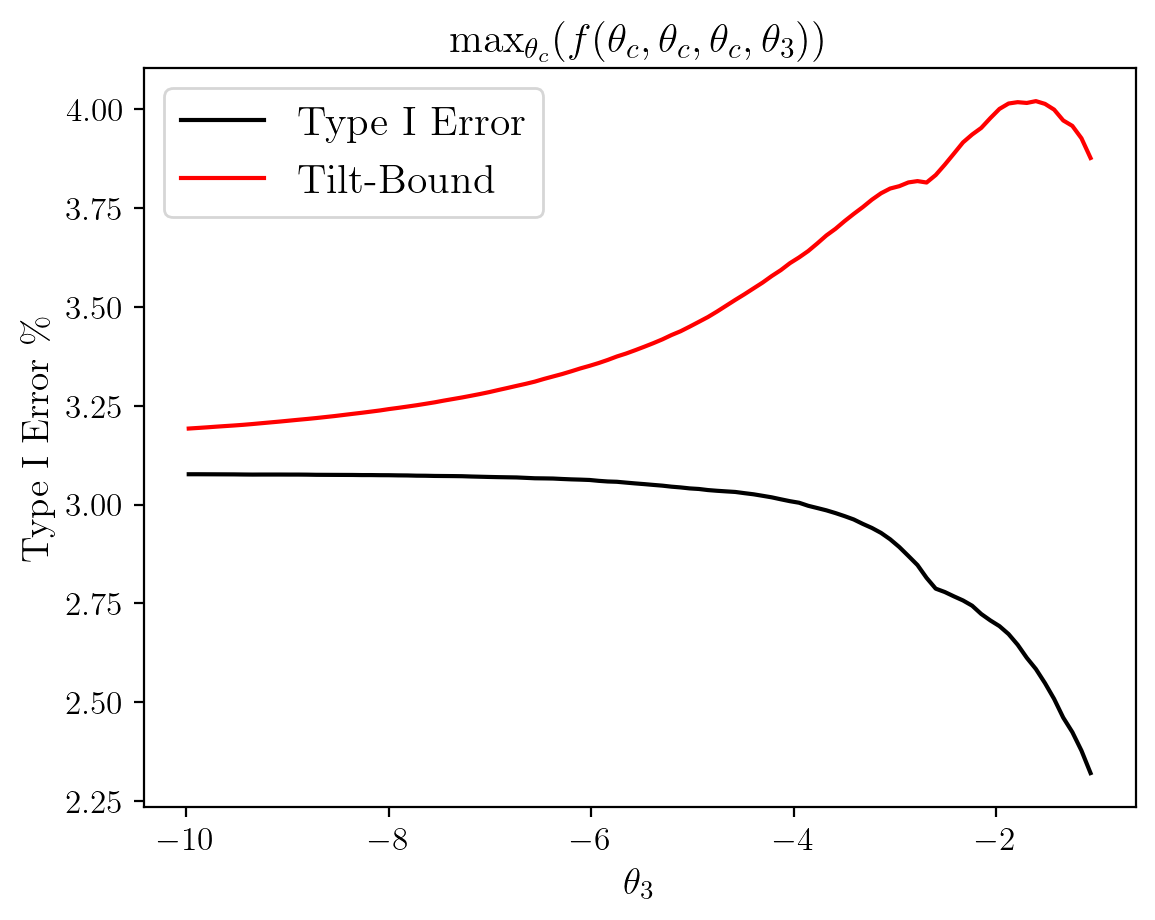

In [17]:
worst_tie = rej_df["tie_est"].values.reshape((100, 20)).max(axis=1)
worst_bound = rej_df["tie_bound"].values.reshape((100, 20)).max(axis=1)
plt.plot(
    g.df["theta3"].values.reshape((100, 20))[:, 0],
    100 * worst_tie,
    "k-",
    label="Type I Error",
)
plt.plot(
    g.df["theta3"].values.reshape((100, 20))[:, 0],
    100 * worst_bound,
    "r-",
    label="Tilt-Bound",
)
plt.legend()
plt.xlabel(r"$\theta_{3}$")
plt.ylabel(r"Type I Error \%")
plt.title(r"$\max_{\theta_c}(f(\theta_c, \theta_c, \theta_c, \theta_3))$")
plt.savefig("lewis_1d_orthogonal.pdf", bbox_inches="tight")
plt.show()